In [181]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Concatenate, Lambda, Layer, RNN
from sklearn.model_selection import KFold
import random
import os


In [182]:
def set_seed(seed_value):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
set_seed(42)


In [183]:
def cross_validate_window_sizes(data, min_window, max_window):
    results = {}
    for window_size in range(min_window, max_window + 1):
        X, y = create_sequences(data.values, window_size)
        
        train_X, test_X = X[:-150], X[-150:]
        train_y, test_y = y[:-150], y[-150:]
        model = Sequential([
            Input(shape=(window_size, train_X.shape[2])),
            SimpleRNN(50, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(train_data, epochs=150, validation_data=test_data,verbose=0)
        mse = model.evaluate(test_X, test_y, verbose=0)
        results[window_size] = mse
    return results


In [184]:
window_size_results = cross_validate_window_sizes(dataset[['close','returns','volume_change']], 2, 30)
best_window_size = min(window_size_results, key=window_size_results.get)
print(f"Best Window Size: {best_window_size}")
# window_size = 8

Best Window Size: 8


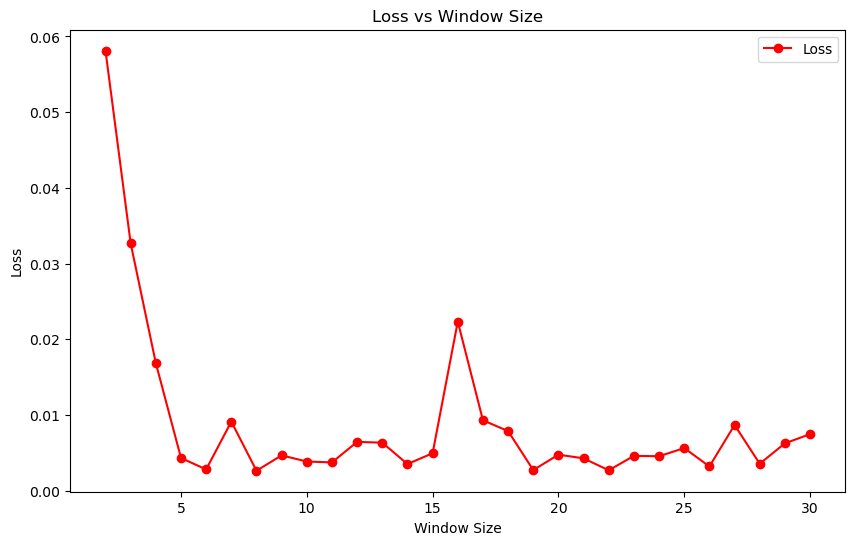

In [185]:
sizes = list(window_size_results.keys())
losses = list(window_size_results.values())

plt.figure(figsize=(10, 6)) 
plt.plot(sizes, losses, 'ro-', label='Loss')
plt.title('Loss vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('Loss')
plt.legend()
plt.savefig("report/window_size.png")
plt.show()


# data preparation

In [143]:
dataset = pd.read_csv("dataset/cleaned_dataset.csv")
dataset.set_index('jdate', inplace=True)
# scaler = StandardScaler()
# dataset = scaler.fit_transform(dataset)

def create_sequences(values, window_size):
    X, y = [], []
    for i in range(len(values) - window_size):
        X.append(values[i:(i + window_size)])
        y.append(values[i + window_size][0])
    return np.array(X), np.array(y)

window_size = 8
X, y = create_sequences(dataset[['close','returns','volume_change']].values, window_size)
train_X, test_X = X[:-150], X[-150:]
train_y, test_y = y[:-150], y[-150:]
train_data = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_data = train_data.batch(32).shuffle(buffer_size=1000)
test_data = tf.data.Dataset.from_tensor_slices((test_X, test_y))
test_data = test_data.batch(32)

# Elman

In [199]:
model = Sequential([
    Input(shape=(window_size, 3)),
    SimpleRNN(100, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(train_data, epochs=150, validation_data=test_data)

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.7540 - val_loss: 0.7403
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1090 - val_loss: 0.0091
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0233 - val_loss: 0.0120
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0125 - val_loss: 0.0088
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - val_loss: 0.0281
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - val_loss: 0.0205
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0149 - val_loss: 0.0285
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114 - val_loss: 0.0145
Epoch 9/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122 - val_loss: 0.0184
Epoch 10/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - val_loss: 0.0240
Epoch 11/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140 - val_loss: 0.0052
Epoch 12/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

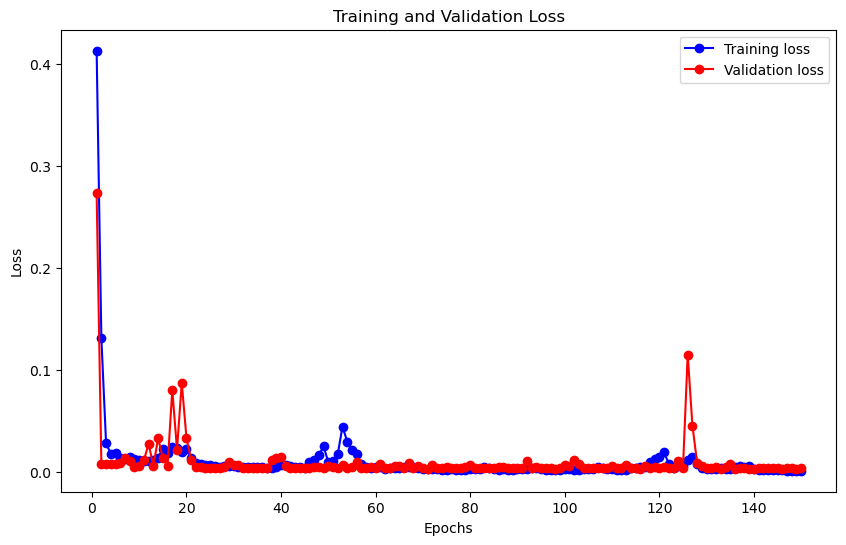

In [196]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 6)) 
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("report/elman_loss.png")
plt.show()

In [197]:
test_loss = model.evaluate(test_data)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


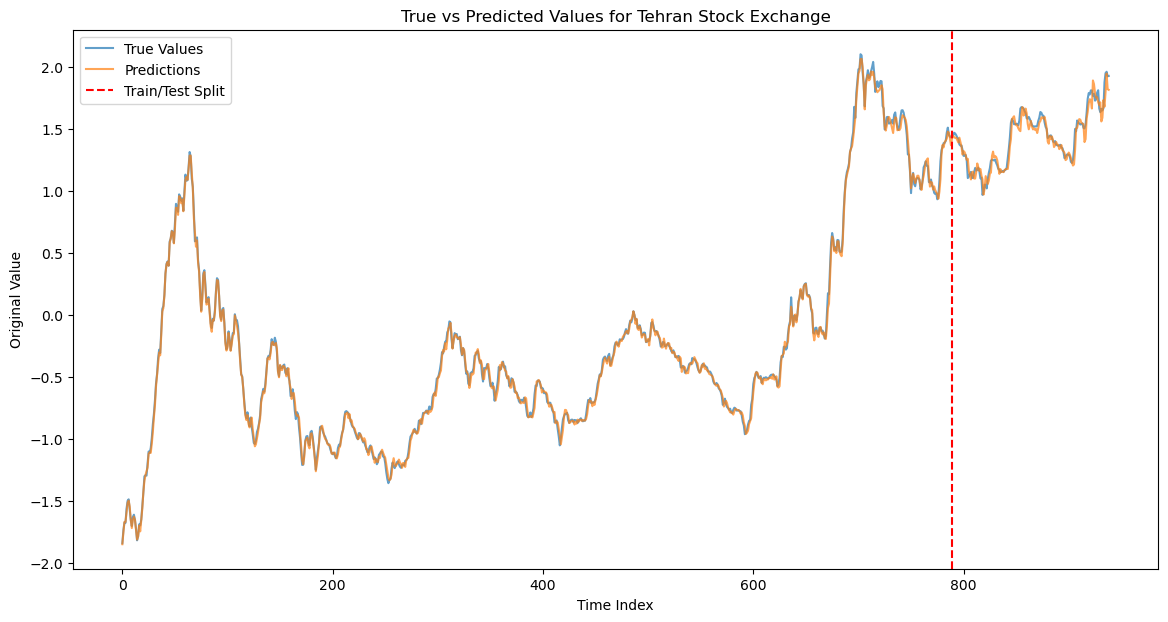

In [198]:
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)
true_values = np.concatenate((train_y, test_y), axis=0)
predictions = np.concatenate((train_predictions, test_predictions), axis=0)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(true_values, label='True Values', alpha=0.7)
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.axvline(x=len(train_y), color='red', linestyle='--', label='Train/Test Split')
plt.title('True vs Predicted Values for Tehran Stock Exchange')
plt.xlabel('Time Index')
plt.ylabel('Original Value')
plt.legend()
plt.savefig("report/elman_predict.png")
plt.show()

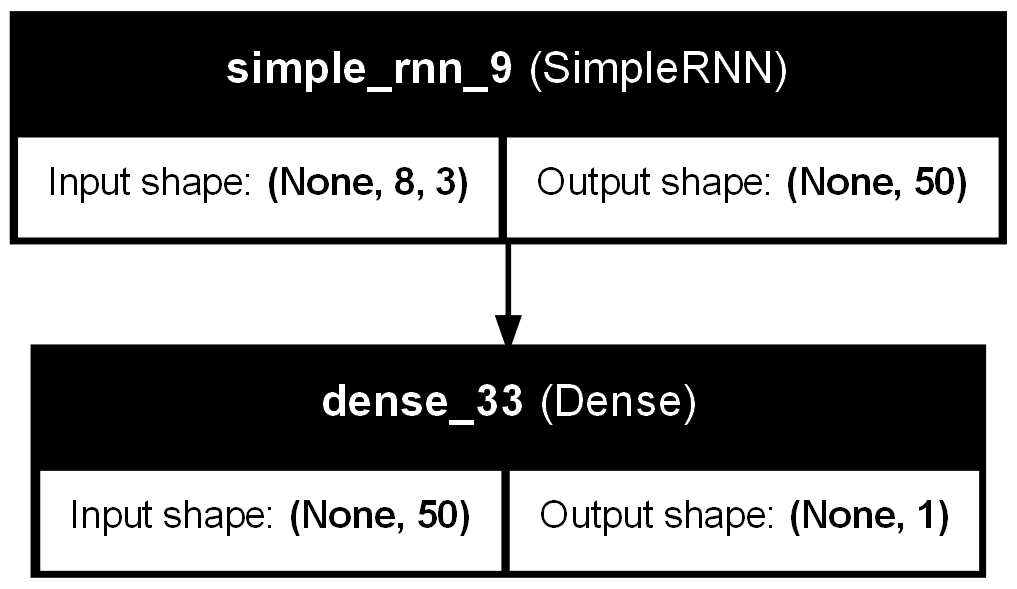

In [121]:
plot_model(model, to_file='report/elman_model.png', show_shapes=True, show_layer_names=True)

# Jordan

In [ ]:
class JordanRNNCell(Layer):
    def __init__(self, h_dim, out_dim):
        super(JordanRNNCell, self).__init__()
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.in_to_h = None
        self.h_to_out = None
        self.out_to_h = None

    def build(self, input_shape):
        self.in_to_h = Dense(self.h_dim, activation='relu')
        self.h_to_out = Dense(self.out_dim)
        self.out_to_h = Dense(self.h_dim, activation='relu')
        super().build(input_shape)

    @property
    def state_size(self):
        return self.out_dim

    def call(self, inputs, states):
        prev_output = states[0]
        h_t = self.in_to_h(inputs) + self.out_to_h(prev_output)
        y_t = self.h_to_out(h_t)
        return y_t, [y_t]

def build_jordan_rnn(input_shape, h_dim, out_dim):
    inputs = Input(shape=input_shape)
    rnn_layer = RNN(JordanRNNCell(h_dim, out_dim), return_sequences=False)(inputs)
    model = Model(inputs=inputs, outputs=rnn_layer)
    return model

window_size = 8
input_shape = (window_size, train_X.shape[2]) 
h_dim =  50
out_dim = 1

jordan_rnn_model = build_jordan_rnn(input_shape, h_dim, out_dim)
jordan_rnn_model.compile(optimizer='adam', loss='mse')
history = jordan_rnn_model.fit(train_X, train_y, epochs=100, validation_data=(test_X, test_y))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.1500 - val_loss: 1.1709
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6718 - val_loss: 0.6306
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3791 - val_loss: 0.1870
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1781 - val_loss: 0.0192
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0931 - val_loss: 0.0087
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0627 - val_loss: 0.0090
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0428 - val_loss: 0.0096
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0297 - val_loss: 0.0102
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0211 - val_loss: 0.0106
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155 - val_loss: 0.0108
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0109
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 6)) 
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("report/jordan_loss.png")
plt.show()

In [114]:
test_loss = jordan_rnn_model.evaluate(test_X, test_y)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


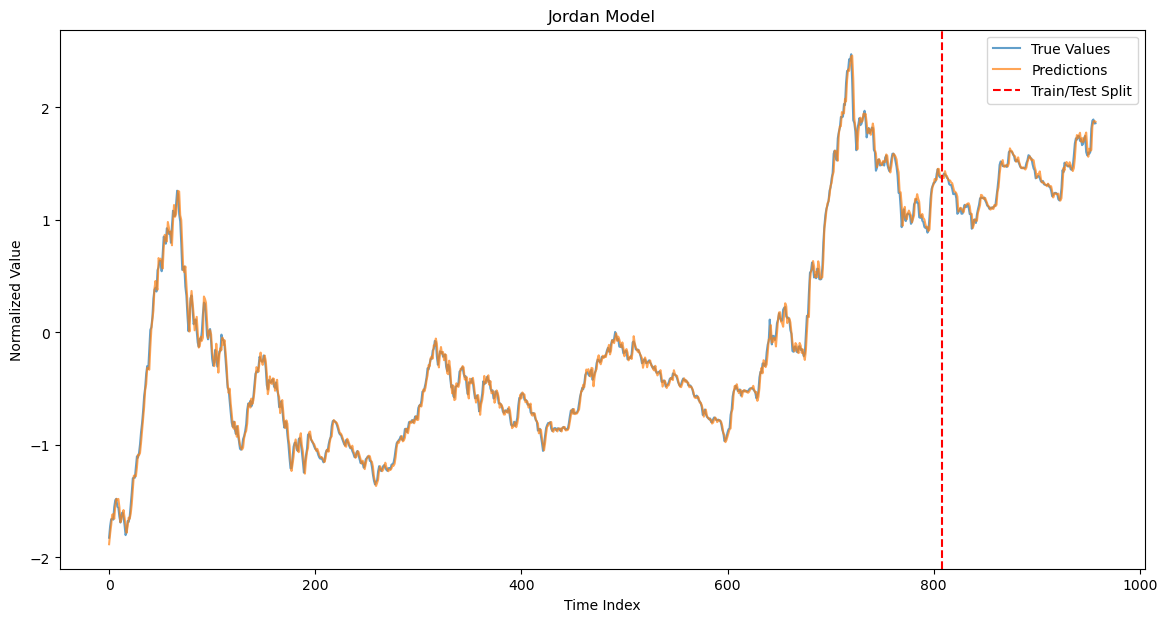

In [115]:
train_predictions = jordan_rnn_model.predict(train_X)
test_predictions = jordan_rnn_model.predict(test_X)
true_values = np.concatenate((train_y, test_y), axis=0)
predictions = np.concatenate((train_predictions, test_predictions), axis=0)
plt.figure(figsize=(14, 7))
plt.plot(true_values, label='True Values', alpha=0.7)
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.axvline(x=len(train_y), color='red', linestyle='--', label='Train/Test Split')
plt.title('Jordan Model')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.legend()
plt.savefig("report/jordan_predict.png")
plt.show()

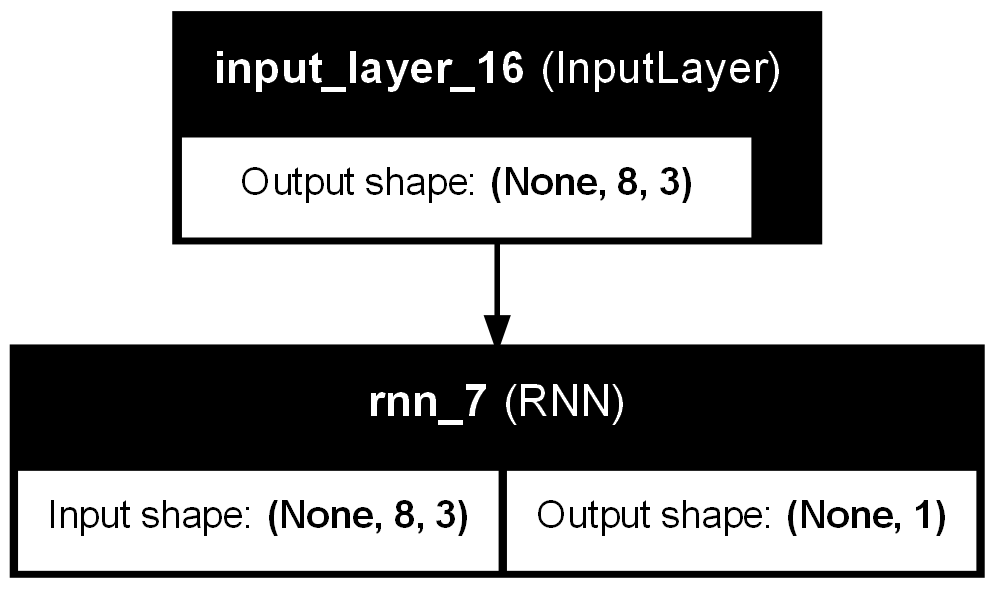

In [116]:
plot_model(jordan_rnn_model, to_file='report/jordan_model.png', show_shapes=True, show_layer_names=True)